In [230]:
import re
import string
import pandas as pd
from math import log
from functools import reduce
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_20newsgroups

In [226]:
categories = ['alt.atheism', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)

In [227]:
def preprocessing(line):
    line = line.lower()
    line = re.sub(r"[{}]".format(string.punctuation), " ", line)
    return line

In [228]:
tfidf_vectorizer = TfidfVectorizer(preprocessor=preprocessing, stop_words="english")
tfidf = tfidf_vectorizer.fit_transform(newsgroups_train.data)

making model...
done
decompoing...


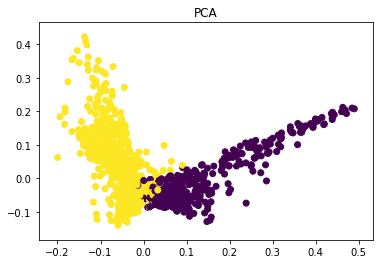

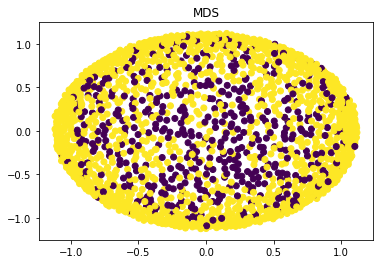

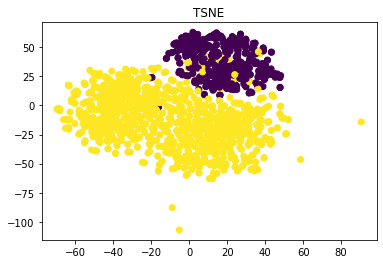

In [224]:
def show_aglom(X):
    print('making model...')
    aglom = AgglomerativeClustering().fit(X.todense())
    print('done')
    def decomp(figure, reduced_features, X):
        plt.figure(figure)
        plt.title(['PCA', 'MDS', 'TSNE'][figure])
        plt.scatter(reduced_features[:,0], reduced_features[:,1], c=aglom.fit_predict(X.todense()))
    print('decompoing...')
    decomp(0, PCA(n_components=2, random_state=42).fit_transform(X.toarray()), X)
    decomp(1, MDS(n_components=2, random_state=42).fit_transform(X.toarray()), X)
    decomp(2, TSNE(n_components=2, random_state=42).fit_transform(X.toarray()), X)
   

show_aglom(tfidf)

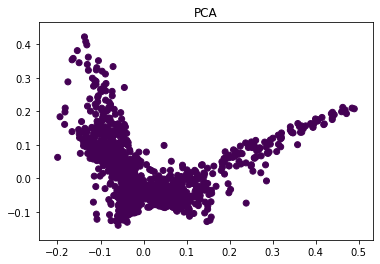

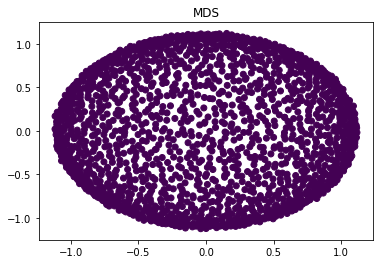

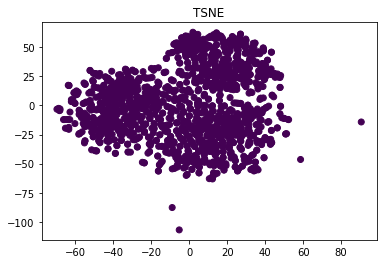

In [213]:
def show_dbscan(X):
    print('making model...')
    dbscan = DBSCAN().fit(tfidf)
    print('done')
    
    def decomp(figure, reduced_features, X):
        plt.figure(figure)
        plt.title(['PCA', 'MDS', 'TSNE'][figure])
        plt.scatter(reduced_features[:,0], reduced_features[:,1], c=dbscan.fit_predict(X))
    print('decompoing...')
    decomp(0, PCA(n_components=2, random_state=42).fit_transform(X.toarray()), X)
    decomp(1, MDS(n_components=2, random_state=42).fit_transform(X.toarray()), X)
    decomp(2, TSNE(n_components=2, random_state=42).fit_transform(X.toarray()), X)
   

show_dbscan(tfidf)

making model...
done
PCA decompoing...
MDS decompoing...
TSNE decompoing...


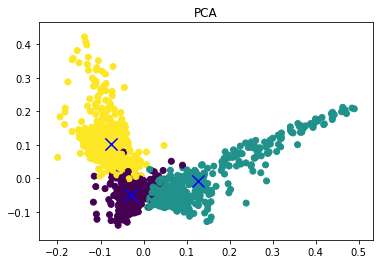

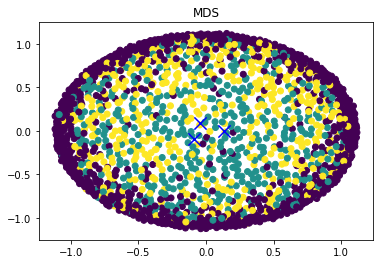

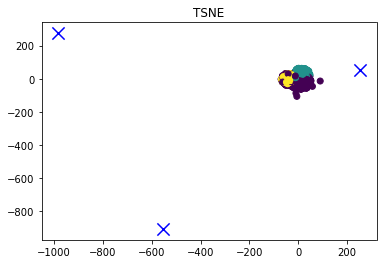

In [223]:
def show_kmeans(X):
    print('making model...')
    kmeans = KMeans(n_clusters=3).fit(X)
    print('done')
    def decomp(figure, reduced_features, reduced_cluster_centers, X):
        plt.figure(figure)
        plt.title(['PCA', 'MDS', 'TSNE'][figure])
        plt.scatter(reduced_features[:,0], reduced_features[:,1], c=kmeans.predict(X))
        plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')
        pca.transform(kmeans.cluster_centers_)
    print('PCA decompoing...')
    pca = PCA(n_components=2, random_state=42)
    decomp(0, pca.fit_transform(X.toarray()), pca.transform(kmeans.cluster_centers_), X)
    print('MDS decompoing...')
    mds = MDS(n_components=2, random_state=42)
    decomp(1, mds.fit_transform(X.toarray()), mds.fit_transform(kmeans.cluster_centers_), X)
    print('TSNE decompoing...')
    tsne = TSNE(n_components=2, random_state=42)
    decomp(2, tsne.fit_transform(X.toarray()), tsne.fit_transform(kmeans.cluster_centers_), X)
   
show_kmeans(tfidf)

In [246]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=1000,
                                stop_words='english')
tf = tf_vectorizer.fit_transform(newsgroups_train.data)

lda = LatentDirichletAllocation(n_components=3, max_iter=10
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
lda.fit(tf)

tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Topic #0: edu god people writes don com think just article like does say know keith atheists atheism believe posting way time
Topic #1: space nasa edu gov data image launch software com earth access orbit research available images program information moon ___ new
Topic #2: edu com university writes posting article host nntp graphics know file don like does thanks just files version jpeg uk

